# 3b Features selection

This notebook was provided as part of [3_Features_extraction_and_selection.ipynb](3_Features_extraction_and_selection.ipynb)  which contains some functions that take some time for execution. This notebook can give better insights in outputs and is easier to follow. For details, please go to:
[3_Features_extraction_and_selection.ipynb](3_Features_extraction_and_selection.ipynb) and execute all cells.


*Before usage of this notebook, please download folder `Files_for_notebooks.zip` from this link https://github.com/harislulic/ZeMA-machine-learning-tutorials/releases/tag/v0.1.2
and store the files in the same folder which is location for this notebook.
It is also necessary to install pip in your environment and using this, package PyDynamic:*

pip install PyDynamic

*In order to see interactive diagrams, write:* 

pip install ipywidgets

jupyter nbextension enable --py widgetsnbextension   

## 3b.1 Introduction

Based on feature extraction, feature selection is performed in the following manners:

- Pearson correlation between these extracted amplitudes and vector with information of degree of wear of electromechanical cylinders. Here, uncertainties are not involved and this case will serve only for comparison.
- Weighted correlation, with uncertainties involved
- Monte Carlo method, with Pearson correlation as model function. Because the estimates of amplitudes and their standard squared uncertainties are only known, random samples are drawn from the normal distribution.

For each of these methods, the best 500 features are selected. In order to reduce computational and memory issues, *Updating formulae* method will be proposed. 

### 3b.1.2 Importing the data 

In [83]:
import h5py                                     # Importing the h5 package.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import dia_matrix
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import os
from scipy.stats import pearsonr
import math  
import multiprocessing
import functools

In [6]:
filename = 'Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                     # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(11):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(11):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]           # Cuting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements in time
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))

    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements in time
    and 6291 represents number of cycles.


### 3.b.1.2 Converting into SI units 

In [15]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor=[0]*len(sensorADC)

for i in range(len(sensorADC)):
    sensor[i]=((sensorADC[i]*gain[i])+offset[i])*b[i]*k[i]


###### If you have problems with previous step, you can skip conversion into SI units by running next cell.

In [ ]:
sensor=sensorADC

### 3.b.1.3 Reading of train and test data
*Note: see [3_Features_extraction_and_selection.ipynb](3_Features_extraction_and_selection.ipynb)  Data were split into train and test data for k=85%*

In [16]:
train_test1= h5py.File("Train_test_data_split","r")

In [17]:
target_train_vector=train_test1["target_train_vector"]
target_test_vector=train_test1["target_test_vector"]

Converting arrays into data frames:

In [18]:
target_train_vector=pd.DataFrame(target_train_vector)
target_test_vector=pd.DataFrame(target_test_vector)

In [19]:
target=list(target_train_vector[0])

So, after this step main data to work on are lists: 

"sensor_train" with their class labels "train_target"
 
and 
 
"sensor_test" with their class labels "test_target"

In [20]:
sensor_train=[0]*11
sensor_test=[0]*11

for i in range(11):
    sensor_train[i]=sensor[i].loc[:,target_train_vector.index]

print("Traning data for one sensor has dimensions: ", sensor_train[10].shape,",      ('sensor_train') ")
print("and it's target vector has length: ", target_train_vector.shape,",               ('target_train_vector') \n")

for i in range(11):
    sensor_test[i]=sensor[i].loc[:,target_test_vector.index]

print("Testing data for one sensor has dimensions: ", sensor_test[10].shape,",      ('sensor_test') ")
print("and it's target vector has length: ", target_test_vector.shape,",        ('target_test_vector') \n")

Traning data for one sensor has dimensions:  (2000, 5347) ,      ('sensor_train') 
and it's target vector has length:  (5347, 1) ,               ('target_train_vector') 

Testing data for one sensor has dimensions:  (2000, 944) ,      ('sensor_test') 
and it's target vector has length:  (944, 1) ,        ('target_test_vector') 



We can have a look at the data from one sensor after splitting for better understanding of structure for next steps. Number of rows is 2000 and each column is one random measurement cycle. Table shows only first five samples in time (five rows) for each cycle. 

In [21]:
sensor_train[0].head()

,0,1,2,3,4,5,6,7,8,9,...,5337,5338,5339,5340,5341,5342,5343,5344,5345,5346
0,-0.052346,0.035353,0.150057,0.165182,0.007607,0.085452,-0.004497,-0.015737,0.004307,0.030425,...,-0.175565,0.329240,0.210907,0.184818,0.050059,0.108024,0.142261,0.358908,0.161659,0.362495
1,0.013661,0.062294,0.073791,0.002720,0.045830,0.097229,0.054530,0.065786,0.283926,0.108324,...,-0.218415,0.447456,0.349365,0.299143,0.048282,0.207124,0.431144,0.638964,0.378436,0.698642
2,0.088680,-0.157930,0.016507,0.020354,0.090973,-0.215526,0.061279,0.034248,0.184389,0.141985,...,-0.369747,0.213356,0.078377,0.058016,-0.075154,0.073886,0.393118,0.545816,0.170193,0.216192
3,0.040834,-0.081864,0.264404,0.090820,0.189913,0.068431,-0.101957,0.105077,0.037419,0.232769,...,0.012711,0.306476,0.201671,0.298681,0.069645,0.011811,0.371483,0.673113,0.286716,0.490413
4,0.033578,-0.044107,0.056629,0.022157,0.091190,-0.215849,-0.147002,0.120792,0.155922,0.038234,...,-0.026665,0.382832,0.299239,0.259937,0.135226,0.151655,0.500641,0.763004,0.247051,0.542166



## 3b.2. Methods for the features selection

Features selection is based on correlation between amplitudes for 10% selected frequencies and target vector which represents label for each cycle and degree of wear of electromechanical cylinders. First method represents Pearson correlation between results obtained from the function `chooseAndReturnOrdered` (does not provide uncertainties) and target vector. It serves for comparison.

Second method represents weighted correlation between results obtained from PyDynamic, based on FFT with uncertainty propagation (they do contain uncertainties) and target vector. Uncertainties are used as weights.

Third method represents Monte Carlo method with Pearson correlation as model function. Random samples were taken from multivariate normal distribution of results obtained from the PyDynamic and the function `chooseAndReturnOrdered_with_uncertainty` . 
 

### 3b.2.1 Feature selection using Pearson correlation coefficients

The method is very simple, Pearson correlation coefficient is calculated between selected features and target vector and it is done for all sensors. After that, number of features with overall highest Pearson correlation coefficients is selected.

#### 3.3.1.1. Pearson correlation

A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related. A correlation coefficient indicates the extent to which dots in a scatterplot lie on a straight line. The stronger the association of the two variables, the closer the Pearson correlation coefficient, r, will be to either +1 or -1 depending on whether the relationship is positive or negative, respectively.

_Pearson correlation formula [3]:_

<img src="pictures/formula1.png">

- $x$ and $y$ are two vectors of length n
- $m_x$ and $m_y$ corresponds to the means of x and y, respectively.

Different relationships and their correlation coefficients are shown in the figure below [4]:

<img src="pictures/Correlation_examples.png">

Function `Pearson_corr` calculates correlation coefficients for the given number of sensors and extracted features. Then, function called `largest_indices` finds indices for wanted amount of features with highest correlation coefficients. 

*Reading the data for 10% of the spectrum with highest average of amplitudes from the file 3_Features_extraction_and_selection.ipynb calculated from FFT:
Values were obtained by using factor of splitting data into train and test from the above.*

In [22]:
amp_fft1= h5py.File("Sorted_vaules_from_all_sensors.hdf5","r")
freq_fft1= h5py.File("Sorted_freq_from_all_sensors.hdf5","r")    

In [23]:
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values_from_all_sensors=[0]*len(sensor_train)
for i in range(len(sensor)):
    freq_of_sorted_values[i]=freq_fft1["freq_of_sorted_values"+str(i)]
    sorted_values_from_all_sensors[i]=amp_fft1["sorted_values_from_all_sensors"+str(i)]

In [24]:
def Pearson_corr(sorted_values,N,n_of_samples):
    corr=np.zeros((len(sorted_values),round((N/100.0)*n_of_samples/2)))                
    p_value=np.zeros((len(sorted_values),round((N/100.0)*n_of_samples/2)))               

    # Calculating correlation coefficients for each column of each sensor with respect to target.
    for j in range(11):
        for i in range(round((N/100.0)*n_of_samples/2)):
            corr[j,i],p_value[j,i]=pearsonr(np.abs(sorted_values[j][:,i]),target_train_vector[0])
    corr_array=(corr)                               
    return corr_array

In [25]:
def largest_indices(array, n):                               # Function that find indices for 500 biggest Pearson-
    """Returns the n largest indices from a numpy array."""  # -correlation coefficients.
    flat = array.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, array.shape)  


#### Function execution

Function output is stored into lists 'sensor_n' and 'feature_n', where element in 'sensor_n' means which sensor, and related element in 'feature_n' means which feature of that sensor is accessed.

In [ ]:
N=10 #percentage of highest amplitudes, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb
n_of_samples=2000 #number of samples, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb

n_features_for_select=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select=n_features_for_select+int(len(sorted_values_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select))


target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", sorted_values_from_all_sensors[0][:,:].shape)

corr_array_p=Pearson_corr(sorted_values_from_all_sensors,N,n_of_samples)
print("Array of correlation coefficients has size:")
print("                                                 ",corr_array_p.shape)  
# sensor_n is the index of the sensor number.
# feature_n is the index of the feature number for each sensor number.
sensor_n, feature_n = largest_indices(corr_array_p, n_of_features)

print("Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(sensor_n)
print("\nColumn indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(feature_n)

Based on the found indices for highest features, all of them are put together into a list *top_n_features*, but separated into sublists based on the sensor they are taken from. Then, by comparing the sizes of these groups it is shown how many of those selected features are from which sensor. This is done with the function  `percentage`

After that, features are merged into one feature matrix *abs_top_n_together_matrix*. Because the output of the FFT from the Numpy library is in form of complex number, absolute values are assigned to the matrix *abs_top_n_together_matrix*. This function is going to be used for *weighted correlation* and *Monte Carlo method*, where these values are already taken as absolute, so it will not affect the results.

In [ ]:
def percentage (sensor_ind,feature_ind,sorted_values_from_all_sensors):
    # Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
    top_n_features=[[], [], [], [], [], [], [], [], [], [], []]
    for i in range(len(sorted_values_from_all_sensors)):
        for j in range(len(sensor_ind)):
            if sensor_ind[j]==i:
                top_n_features[i].append(sorted_values_from_all_sensors[i][:,feature_ind[j]]);

    for i in range(len(sorted_values_from_all_sensors)):
        for j in range(len(top_n_features[i])):
            top_n_features[i][j]=list(top_n_features[i][j])

    # Merging sublists into one list with all elements.
    top_n_together=[j for i in top_n_features for j in i]  

    top_n_together_matrix=np.transpose(pd.DataFrame(top_n_together))
    print(type(top_n_together_matrix), "\n")

    # Continue working with abosulte values.
    abs_top_n_together_matrix=np.abs(top_n_together_matrix)

    percentage=[None]*(len(sorted_values_from_all_sensors))
    k=0
    for i in range(len(sorted_values_from_all_sensors)):
        #print(top_n_features_matrix.shape)
        print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features[i]), len(top_n_features[i])/len(sensor_ind)*100))
        percentage[i]=len(top_n_features[i])
        k=k+len(top_n_features[i])/len(sensor_ind)*100
    print("----------------------------------------------------")
    print("                                             %4.2f" % (k))

    return percentage,abs_top_n_together_matrix

In [28]:
abs_top_n_together_matrix=np.zeros((sorted_values_from_all_sensors[0].shape[0], n_features_for_select))
percentage_p,abs_top_n_together_matrix=percentage(sensor_n,feature_n,sorted_values_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  76 or  15.20 %
Number of features from sensor  1 is:  38 or  7.60 %
Number of features from sensor  2 is:  80 or  16.00 %
Number of features from sensor  3 is:  77 or  15.40 %
Number of features from sensor  4 is:   5 or  1.00 %
Number of features from sensor  5 is:   6 or  1.20 %
Number of features from sensor  6 is:   5 or  1.00 %
Number of features from sensor  7 is:  72 or  14.40 %
Number of features from sensor  8 is:  50 or  10.00 %
Number of features from sensor  9 is:  45 or  9.00 %
Number of features from sensor 10 is:  46 or  9.20 %
----------------------------------------------------
                                             100.00


###  3b.3 Weighted correlation

A weighted correlation allows application of a weight, or relative significance to each value comparison. Correlation comparisons with a higher value for their weight are considered as more significant when compared to the other value comparisons. Weighted correlation requires following arguments:

- *x* and *y* are - values being compared.
- *w* is the weight applied to each comparison. With these arguments, it is possible to calculate:

weighted mean:
$$m(x;w)=\frac {\sum_{i}w_i*x_i}{\sum_{i}w_i}$$ 
weighted covariance:
$$cov(x,y;w)=\frac {\sum _{i}w_i(x_i-m(x;w))(y_i-m(y;w))}{\sum _{i}w_i} $$
weighted correlation:
$$corr(x,y;w)=\frac{cov(x,y;w)}{\sqrt{cov(x,x;w)*cov(y,y;w))}}$$

In this case, correlation is weighted with weight factor:
$$ w_i= \frac {1}{u²({x_i})}$$
where $x_{i}$ represents amplitudes and $u²(x_{i})$ their standard squared uncertainties. These values from all sensors are converted into numpy arrays because it is assumed to be more efficient.


*Results of extracting 10% of highest amplitudes by DFT can be read in the next steps. Values were obtained by using factor of splitting data into train and test from 3.b.1.3.  $\sigma$ , representing white noise was assumed as 0.1.*

In [48]:
amp_dft2= h5py.File("DFTSorted_vaules__from_all_sensors.hdf5","r")
freq_dft2= h5py.File("DFTSorted_freq_from_all_sensors.hdf5","r") 
ph_dft2= h5py.File("DFTSorted_ph_from_all_sensors.hdf5","r")
u_a_dft2= h5py.File("DFTSorted_uncer_from_all_sensors_a.hdf5","r")
u_ap_dft2= h5py.File("DFTSorted_uncer_from_all_sensors_ap.hdf5","r")    
u_pp_dft2= h5py.File("DFTSorted_uncer_from_all_sensors_pp.hdf5","r")    

In [49]:
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values_amp_from_all_sensors=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_a=[0]*len(sensor_train)
for i in range(len(sensor)):
    freq_of_sorted_values[i]=freq_dft2["freq_of_sorted_values"+str(i)]
    sorted_values_amp_from_all_sensors[i]=amp_dft2["sorted_values_amp_from_all_sensors"+str(i)]
    sorted_uncer_from_all_sensors_a[i]=u_a_dft2["sorted_uncer_from_all_sensors_a"+str(i)]
    

Weights are calculated according to the code in the next cell:

In [50]:
#Calculating weights from diagonal elements of uncertainty matrix
# W -list of eleven np.arrays sized (number of cycles, N% of amplitudes) containing weight factors
W=[None]*len(sorted_values_amp_from_all_sensors)
B=np.zeros((sorted_values_amp_from_all_sensors[0].shape))
for k in range(len(sorted_values_amp_from_all_sensors)):
    for i in range (sorted_values_amp_from_all_sensors[0].shape[0]):
        B[i]=1/((sorted_uncer_from_all_sensors_a[k][i,:])) #elements in u_a already squared
    W[k]=B

Functions `m`, `cov` and `corr` will calculate the weighted mean, weighted covariance and weighted correlation for their arguments.

In [35]:
#weighted mean
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)
#weighted covariance
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)
#weighted correlation
def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

Implementing functions `m`, `cov` and `corr` for the largest correlation coefficients:

In [ ]:
n_features_for_select_w=0
for i in range(len(sorted_values_amp_from_all_sensors)):
    n_features_for_select_w=n_features_for_select_w+int(len(sorted_values_amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest correllation coeff. will be selected.
n_of_features_w = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_w))


target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", sorted_values_amp_from_all_sensors[0].shape)

weighted_mean=np.zeros((len(sorted_values_amp_from_all_sensors),(round((N/100.0)*n_of_samples/2))))                      
weighted_covariance=np.zeros((len(sorted_values_amp_from_all_sensors),(round((N/100.0)*n_of_samples/2)))) 
weighted_corelation=np.zeros((len(sorted_values_amp_from_all_sensors),(round((N/100.0)*n_of_samples/2))))  

# Calculating weighted correlation coefficients for each column of each sensor with respect to target.
for j in range(11):
    for i in range(round((N/100.0)*n_of_samples/2)):
        weighted_mean[j,i]=m(sorted_values_amp_from_all_sensors[j][:,i],W[j][:,i])
        weighted_covariance[j,i]=cov(sorted_values_amp_from_all_sensors[j][:,i],target_train_vector[0],W[j][:,i])
        weighted_corelation[j,i]=corr(sorted_values_amp_from_all_sensors[j][:,i],target_train_vector[0],W[j][:,i])
    
corr_array_w=weighted_corelation 

print("Array of weighted correlation coefficients has size:")
print("                                                 ",corr_array_w.shape)  

sensor_n_w, feature_n_w = largest_indices(corr_array_w, n_of_features_w)

print("Sensor indices of location of features in >sorted_values_amp_from_all_sensors< matrix: \n")
print(sensor_n_w)
print("\nColumn indices of location of features in >sorted_values_amp_from_all_sensors< matrix: \n")
print(feature_n_w)

Representation of sensors in percentages for each trial has been given in the list percentage_w and features have been stored in matrix *abs_top_n_together_matrix_w*:

In [52]:
abs_top_n_together_matrix_w=np.zeros((sorted_values_amp_from_all_sensors[0].shape[0],n_features_for_select))
percentage_w,abs_top_n_together_matrix_w=percentage(sensor_n_w,feature_n_w,sorted_values_amp_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  76 or  15.20 %
Number of features from sensor  1 is:  38 or  7.60 %
Number of features from sensor  2 is:  80 or  16.00 %
Number of features from sensor  3 is:  77 or  15.40 %
Number of features from sensor  4 is:   5 or  1.00 %
Number of features from sensor  5 is:   6 or  1.20 %
Number of features from sensor  6 is:   5 or  1.00 %
Number of features from sensor  7 is:  72 or  14.40 %
Number of features from sensor  8 is:  50 or  10.00 %
Number of features from sensor  9 is:  45 or  9.00 %
Number of features from sensor 10 is:  46 or  9.20 %
----------------------------------------------------
                                             100.00


The mean values of correlation coefficients for all sensors in case of methods: Weighted correlation and Pearson correlation are presented. It is visible that for this case, both methods provide the same results. Uncertainties considered as weights do not have impact on selection of the features, which is a consequence of considering only white noise, that has constant power. It might be interesting to see the results in the case of coloured noise. The calculation was also performed with $\sigma$  value = 0.1.

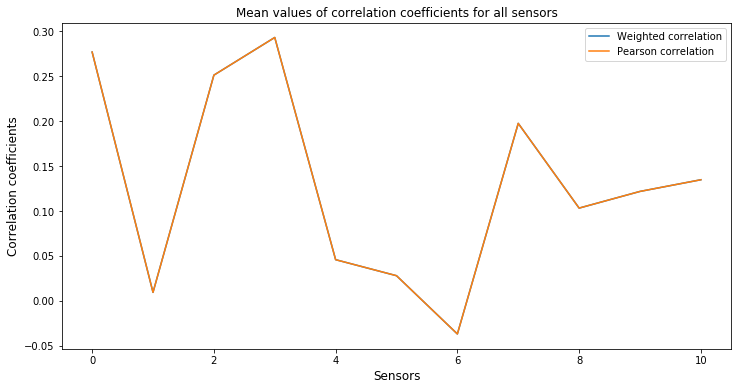

In [53]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0,len(sensor)), corr_array_w.mean(axis=1),label=("Weighted correlation"))
plt.plot(np.arange(0,len(sensor)), corr_array_p.mean(axis=1),label=("Pearson correlation"))
plt.xlabel('Sensors' ,fontsize=12)
plt.title("Mean values of correlation coefficients for all sensors")
plt.ylabel('Correlation coefficients' ,fontsize=12)
plt.legend()

Correlation coefficients will be shown for all amplitudes of given sensor. In general, the total number of sensors should be entered for the variable *i* in the function  `corr_coefs_for_highest_amp´`.

In [39]:
def corr_coefs_for_highest_amp(i):
    plt.figure(figsize=(12,6))
    plt.plot(np.arange(0,len( corr_array_w[i])), corr_array_w[i],label=("Weighted correlation"))
    plt.plot(np.arange(0,len(corr_array_p[i])), corr_array_p[i],label=("Pearson correlation"))
    plt.xlabel('Sensors' ,fontsize=12)
    plt.title("Mean values of correlation coefficients for all sensors")
    plt.ylabel('Correlation coefficients' ,fontsize=12)
    plt.legend()
interact(corr_coefs_for_highest_amp,i=widgets.IntSlider(min=0,max=11,step=1))

interactive(children=(IntSlider(value=0, description='i', max=11), Output()), _dom_classes=('widget-interact',…

<function __main__.corr_coefs_for_highest_amp(i)>

### 3b.4 Monte Carlo method for the feature selection

Features with highest Pearson correlation coefficients through *M* Monte Carlo trials are selected.

The idea of Monte Carlo (MC) method is to draw random samples of input quantities from their probability density functions (PDFs). For each of the *M* draws, the model between output and input quantities is evaluated for all input quantities. The result of the MC is the estimate of the output quantity and the associated standard uncertainty: 

- best estimate $\mathbf{y}$,is calculated as the mean value of all evaluations of the model (one sample, one evaluation - trial):
\begin{align}
\mathbf{y}=& mean \{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M} \sum_{k=1}^M \mathbf{y}^{(k)}
\end{align}
- uncertainty associated with the best estimate
\begin{align}
U_\mathbf{y} =& cov\{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M-1} \sum_{k=1}^M (\mathbf{y}^{(k)}-\mathbf{y})^T(\mathbf{y}^{(k)}-\mathbf{y})
\end{align}

For ZeMA sensors, samples are be drawn from the multivariate normal distribution, since the correlation between amplitudes at 10% of spectrum is zero. In this case, the model is Pearson correlation. The output quantity is the estimate of correlation coefficients and their uncertainties. With these coefficients, features are selected.

#### 3b.4.1 MC in steps

Function `draw_random_samples` will draw samples for all sensors from the multivariate normal distribution, where amplitudes are means and standard deviations are their standard squared uncertainties. The function returns variable *ind* which is a list of drawn samples. One sample has dimensions of 3D array. For example (11,5347,100): 11 sensors, 5347 cycles and 100 amplitudes. It is recommended to define up to 100 samples, because the number of cycles is large and memory issues can arise. 

The application of Monte Carlo method can be stated through following steps:

1) `draw_random_samples` -  Multivariate normal distribution with zero correlation was defined. 

*Note: Despite the mathematical and physical connection of amplitude and phase, in many practical cases the covariances  are considered to be zero.*

In [54]:
A_array=np.asarray(sorted_values_amp_from_all_sensors)
UA_array=np.asarray(sorted_uncer_from_all_sensors_a)

In [46]:
A_array=np.asarray(sorted_values_amp_from_all_sensors)
UA_array=np.asarray(sorted_uncer_from_all_sensors_a)

In [55]:
def draw_random_samples(draws):   
    ind=[np.zeros(A_array.shape)]*draws
    for i in range(draws):
        r=np.random.randn(*A_array.shape)
        ind[i]=A_array+r*(np.sqrt(UA_array))
        
    return ind

The number of trials (samples) can be specified by user. Samples are stored in the list *A*.

In [56]:
trials=int(input("Enter the number of MC trials:"))
A=draw_random_samples(trials)

Enter the number of MC trials:10


2) Function `Perform_MC`´ accepts:

- *samples* - drawn samples, 
- *N* - the percentage of extracted amplitudes, 
- *n_of_points* - the number of points of time signal (2000).
- *n_of_features_x* - number of features that are to be selected

as arguments. 

The function uses Pearson correlation as model function. Outputs of the model function are used in the function `largest_indices` to select the features from the sensors.

Function `Perform_MC`´ returns:
- corr_array - list with *trials* elements, containing the correlation coefficients for all sensors. It will serve only for visualization 
- sensor_n_x - containing sensor indices for the best estimate of correlation coefficients. 
- feature_n_x - containing the feature indices in *sensor_n_x* for the best estimate of correlation coefficients.
- corr_array_mean - best estimate of correlation coefficients for all sensors. This will be further analyzed.
- Uy  - uncertainty associated with the best estimate of correlation coefficients for all sensors. This will be further analyzed.

The procedure of `Perform_MC` is explained on the scheme for 10% of extracted features from eleven sensors and ten trials:
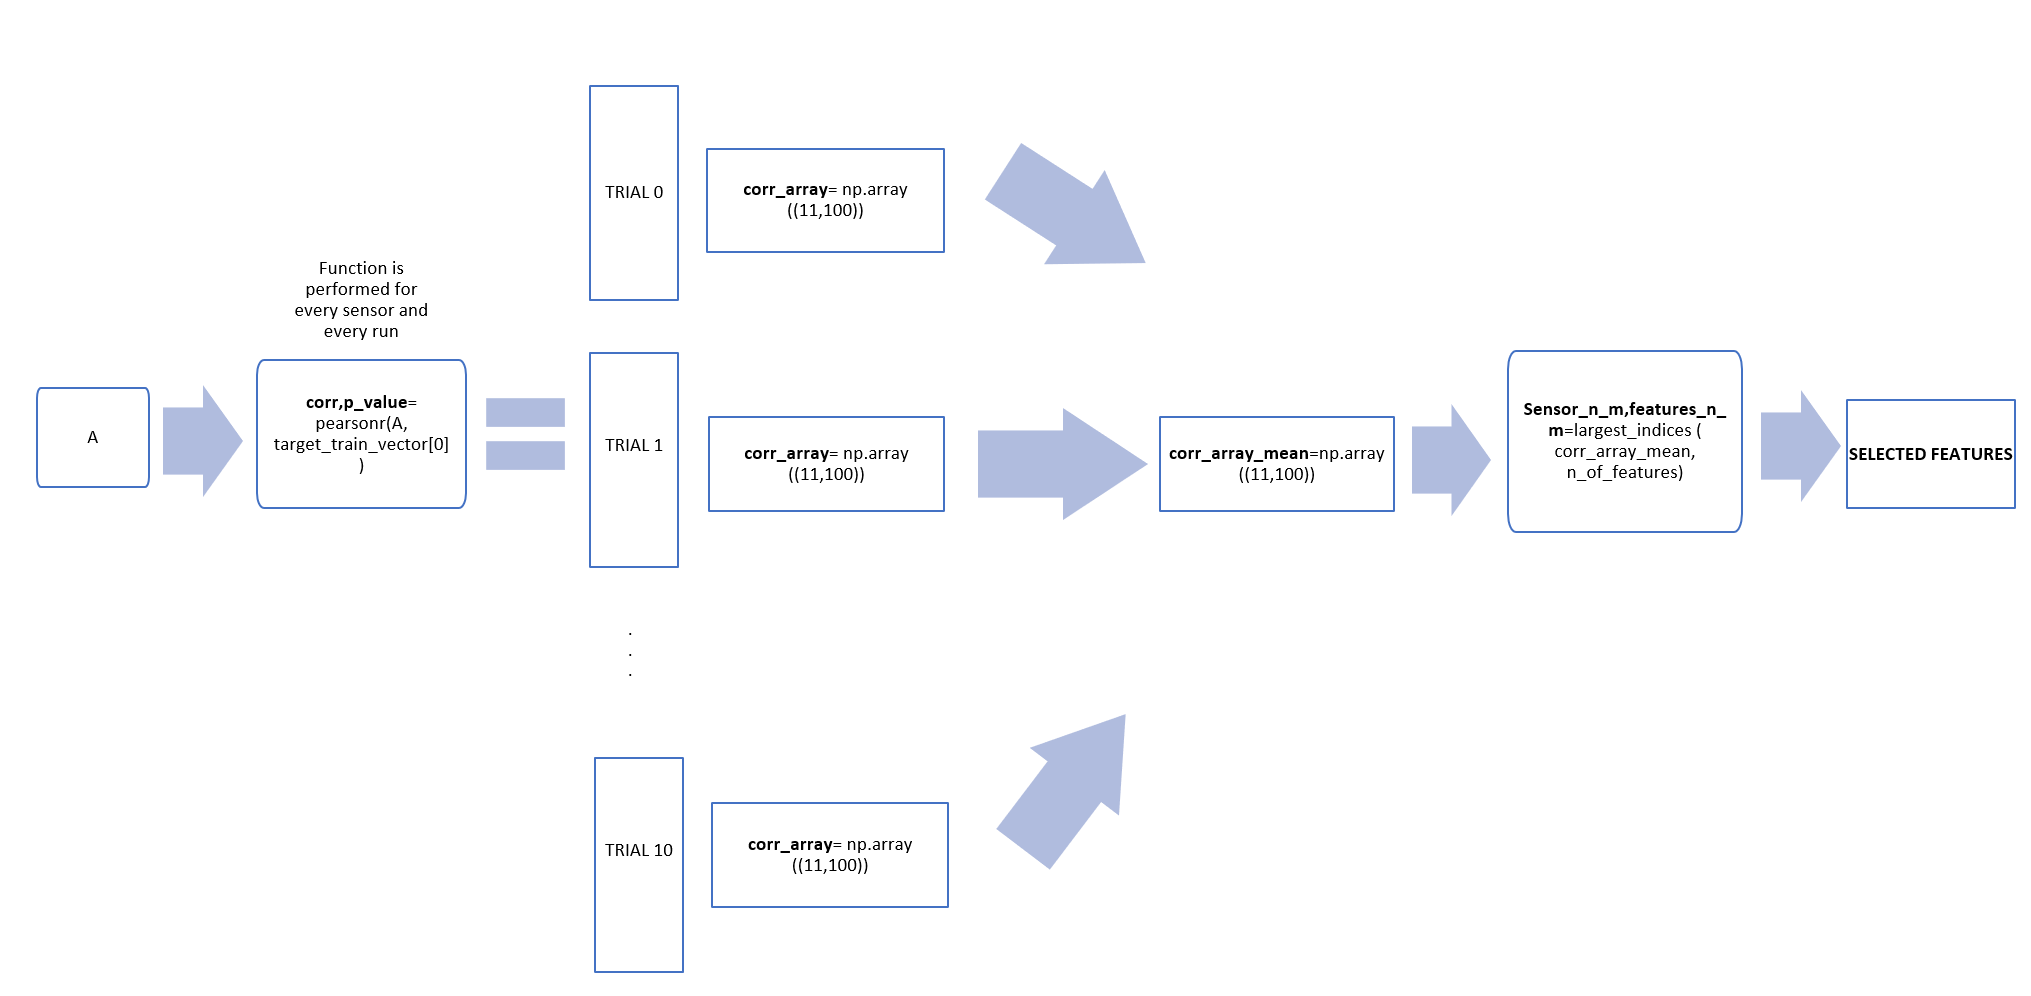

In [57]:
def Perform_MC(samples,N,n_of_points,n_of_features_x):   
    
    target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"
    print("\nDimension of target matrix is:")
    print("                                                 ", target_train_vector.shape)
    print("Dimension of amplitude matrix for one sensor is:")
    print("                                                 ", sorted_values_from_all_sensors[0][:,:].shape)
    corr_array_MC=[None]*(len(samples))
    for s in range(len(samples)):
        corr_array_MC[s]=Pearson_corr(samples[s],N,n_of_points)
                                            
    corr_array=[None]*(len(samples)) # Transforming list of correlation coefficients to nparray
    for p in range(len(samples)):
        corr_array[p]=np.array(corr_array_MC[p])   
        
    #mean value - best estimate

    corr_array_mean=np.mean(corr_array_MC,axis=0) 
    sum2=0
    for s in range(len(samples)):
        sum2=sum2+np.matmul((corr_array_MC[s]-corr_array_mean).T,(corr_array_MC[s]-corr_array_mean))
    Uy=(1/(len(samples)-1))*sum2

    # Transforming list of correlation coefficients to nparray

    print("Array of correlation coefficients for one trial has size:",corr_array[0].shape)
      
    print("Mean array of correlation coefficients for one trial has size:",corr_array_mean.shape)  
    print("Covariance matrix of correlation coefficients for one trial has size:",Uy.shape)  

    # sensor_n_x is the index of the sensor number.
    # feature_n_x is the index of the feature number for each sensor number.

   
    sensor_n_x, feature_n_x = largest_indices(corr_array_mean, n_of_features_x)

    print("Sensor indices of location of features for the best estimate in >sorted_values__amp_from_all_sensors< matrix  \n")
    print(sensor_n_x)
    print("\nColumn indices of location of features for the best estimate in >sorted_values__amp_from_all_sensors< matrix \n")
    print(feature_n_x)

    return corr_array,sensor_n_x,feature_n_x,corr_array_mean,Uy

###### Function execution

In [ ]:
N=10 
n_of_points=2000 #number of points in time domain, see:3_Features_extraction_and_selection.ipynb
n_features_for_select_x=0
for i in range(len(sorted_values_amp_from_all_sensors)):
    n_features_for_select_x=n_features_for_select_x+int(len(sorted_values_amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_x = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_x))

corr_array_MC,sensor_n_m,feature_n_m,corr_array_mean,Uy_mean=Perform_MC(A,N,n_of_samples,n_of_features_x)

Representation of sensors in percentages for each trial has been given *percentage_m* and features are stored in *abs_top_n_together_matrix_m*:

In [59]:
abs_top_n_together_matrix_m=np.zeros((sorted_values_amp_from_all_sensors[0].shape[0],n_features_for_select_x))
percentage_m,abs_top_n_together_matrix_m=percentage(sensor_n_m,feature_n_m,sorted_values_amp_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  82 or  16.40 %
Number of features from sensor  1 is:  43 or  8.60 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  10 or  2.00 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   8 or  1.60 %
Number of features from sensor  7 is:  40 or  8.00 %
Number of features from sensor  8 is:  46 or  9.20 %
Number of features from sensor  9 is:  53 or  10.60 %
Number of features from sensor 10 is:  48 or  9.60 %
----------------------------------------------------
                                             100.00


Now, for selected features, we can also take their uncertainties:

In [72]:
top_n_uncertainties=[[], [], [], [], [], [], [], [], [], [], []]
for i in range(len(sorted_values_from_all_sensors)):
    for j in range(len(sensor_n_m)):
        if sensor_n_m[j]==i:
            top_n_uncertainties[i].append(sorted_uncer_from_all_sensors_a[i][:,feature_n_m[j]]);

for i in range(len(sorted_uncer_from_all_sensors_a)):
    for j in range(len(top_n_uncertainties[i])):
        top_n_uncertainties[i][j]=list(top_n_uncertainties[i][j])

    # Merging sublists into one list with all elements.
top_n_uncertaintites_together=[j for i in top_n_uncertainties for j in i]  

top_n_uncertainties_matrix=np.transpose(pd.DataFrame(top_n_uncertaintites_together))
print(type(top_n_uncertainties_matrix), "\n")

<class 'pandas.core.frame.DataFrame'> 



Mean correlation coefficients for sensors are:

In [60]:
corr_array_mean_df=pd.DataFrame(corr_array_mean)
corr_array_mean_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.383568,0.758842,-0.530043,0.473546,-0.497395,-0.097056,0.377660,-0.732121,0.343722,0.359241,...,0.019813,0.221462,0.269387,0.431642,-0.056198,0.561594,0.553607,0.102581,0.001864,0.330328
1,0.569002,0.282165,0.578622,-0.104974,0.333055,-0.531791,-0.011577,-0.273586,0.205973,-0.371131,...,0.088853,-0.096098,-0.143498,0.116468,-0.152505,-0.163238,-0.143181,-0.002095,-0.017447,0.113677
2,-0.724524,-0.826199,-0.687119,-0.547436,-0.824486,-0.291296,0.187929,0.462671,0.111047,0.011659,...,-0.008708,0.249816,0.403107,0.206267,0.404538,0.383658,-0.020965,0.646287,0.668829,-0.515812
3,-0.261651,0.577937,0.636514,0.318024,0.589643,0.508133,0.544208,0.585173,0.354943,0.493598,...,0.035167,-0.062218,0.295177,-0.056649,-0.090604,0.174722,0.112008,0.449607,0.382525,-0.378506
4,0.061523,0.064766,0.011693,-0.021658,-0.022542,0.014220,0.083143,0.225278,0.104831,0.130786,...,0.033425,0.002224,0.013008,0.004815,0.001077,-0.001905,0.007874,0.031551,0.006176,0.005124


In [61]:
Uy_mean_df=pd.DataFrame(Uy_mean)
Uy_mean_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000068,-0.000018,0.000021,-0.000009,-0.000018,0.000017,1.814363e-06,-0.000009,0.000052,-0.000013,...,0.000002,4.070784e-06,-0.000040,0.000051,0.000004,0.000017,0.000031,-0.000011,-0.000075,0.000031
1,-0.000018,0.000122,-0.000009,-0.000019,0.000021,-0.000011,5.296562e-07,0.000038,-0.000056,-0.000051,...,-0.000020,6.854632e-06,-0.000033,-0.000086,0.000038,-0.000056,-0.000041,0.000014,0.000016,-0.000152
2,0.000021,-0.000009,0.000255,0.000025,-0.000023,-0.000008,-1.921100e-05,0.000001,0.000067,0.000146,...,0.000018,1.921731e-05,-0.000068,0.000052,-0.000072,0.000010,-0.000141,-0.000053,-0.000056,0.000143
3,-0.000009,-0.000019,0.000025,0.000254,-0.000006,-0.000026,-7.921515e-05,-0.000035,-0.000034,-0.000039,...,-0.000019,2.780979e-07,0.000022,-0.000002,-0.000024,0.000044,-0.000164,-0.000008,-0.000001,-0.000053
4,-0.000018,0.000021,-0.000023,-0.000006,0.000314,-0.000016,6.475168e-05,-0.000058,-0.000018,0.000005,...,0.000027,-8.573087e-05,-0.000023,0.000092,0.000029,0.000036,0.000050,0.000040,-0.000056,-0.000052


Mean values of correlation coefficients for all methods are shown in the next plot. As mentioned before, *Weighted correlation* and *Pearson correlation* without uncertainties provide the same result. Results obtained by Monte Carlo method differs from others mostly for the sensors with an index 6 and above.

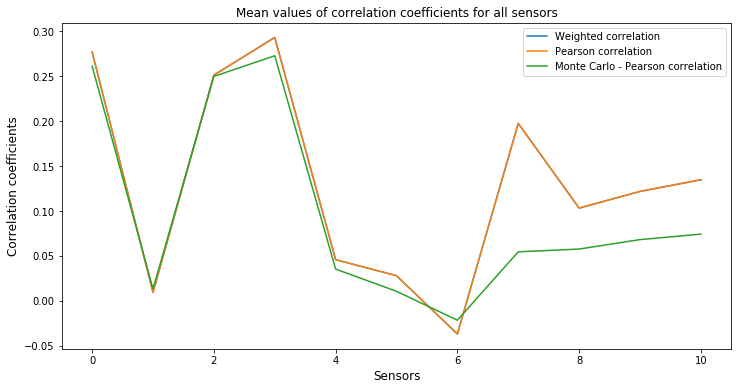

In [62]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0,len(sensor)), corr_array_w.mean(axis=1),label=("Weighted correlation"))
plt.plot(np.arange(0,len(sensor)), corr_array_p.mean(axis=1),label=("Pearson correlation"))
plt.plot(np.arange(0,len(corr_array_mean.mean(axis=1))), corr_array_mean.mean(axis=1),label=("Monte Carlo - Pearson correlation"))
plt.xlabel('Sensors' ,fontsize=12)
plt.title("Mean values of correlation coefficients for all sensors")
plt.ylabel('Correlation coefficients' ,fontsize=12)
plt.legend()

We can observe correlation coefficients for all amplitudes of sensors.

In [64]:
def corr_coefs_for_highest_amp_with_MC(i):
    plt.figure(figsize=(12,6))
    plt.plot(np.arange(0,len( corr_array_w[i])), corr_array_w[i],label=("Weighted correlation"))
    plt.plot(np.arange(0,len(corr_array_p[i])), corr_array_p[i],label=("Pearson correlation"))
    plt.plot(np.arange(0,len(corr_array_mean[i])), corr_array_mean[i],label=("Monte Carlo - Pearson correlation"))
    plt.xlabel('Sensors' ,fontsize=12)
    plt.title("Mean values of correlation coefficients for all sensors")
    plt.ylabel('Correlation coefficients' ,fontsize=12)
    plt.legend()
interact(corr_coefs_for_highest_amp_with_MC,i=widgets.IntSlider(min=0,max=11,step=1))

interactive(children=(IntSlider(value=0, description='i', max=11), Output()), _dom_classes=('widget-interact',…

<function __main__.corr_coefs_for_highest_amp_with_MC(i)>

From these information and percentages, conclusion about how valuable is each of the sensors for this kind of prediction. Differences in contributions are visualised for all methods in a pie chart.

Percentages of features from each sensor are:


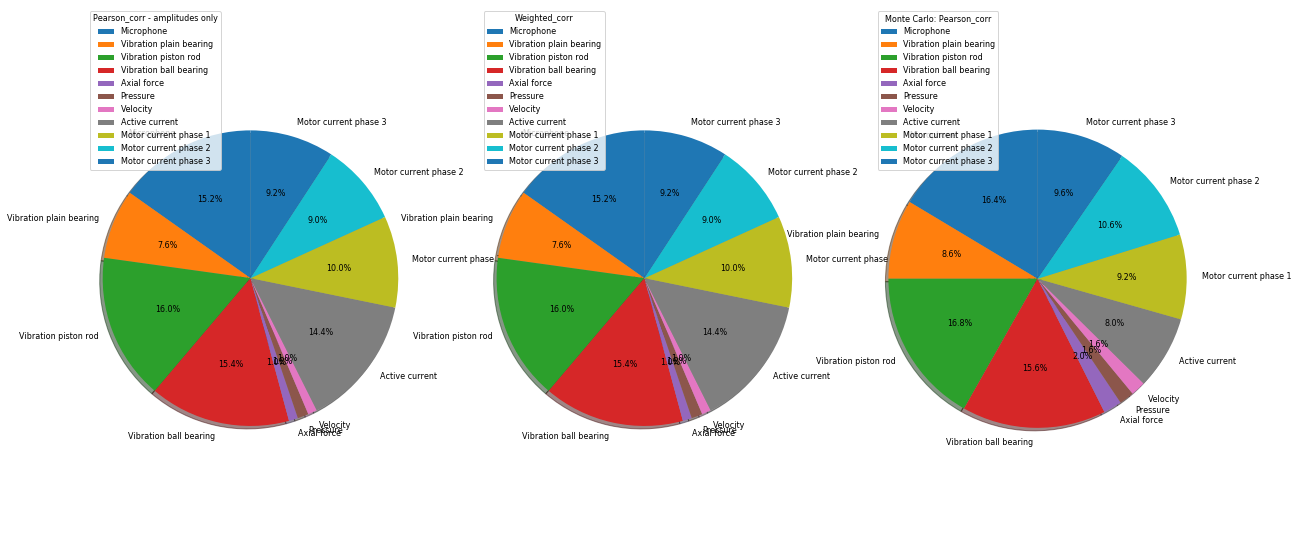

In [65]:
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['font.size'] = 8.0
labels = 'Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3'
print("Percentages of features from each sensor are:")

fig1,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))
   
ax1.pie(percentage_p, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.legend(title="Pearson_corr - amplitudes only")
ax2.pie(percentage_w,labels=labels, autopct='%1.1f%%', shadow=True, startangle=90 )
ax2.axis('equal')
ax2.legend(title="Weighted_corr")
ax3.pie(percentage_m, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax3.axis('equal')
ax3.legend(title="Monte Carlo: Pearson_corr")
# plot each pie chart in a separate subplot

plt.show()

Enter indices of two features out of 500 for ploting (0-499): 55 56


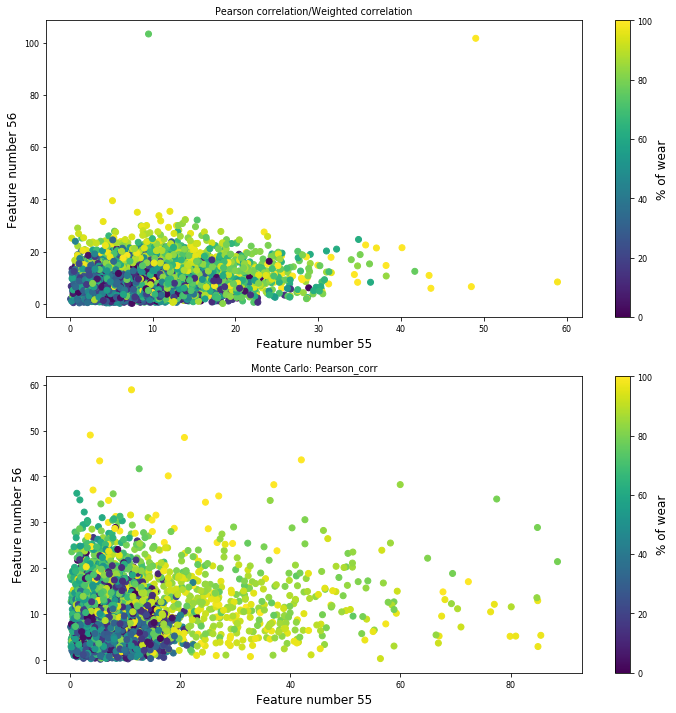

In [66]:
x1, x2 = input("Enter indices of two features out of %s for ploting (0-499): " % n_of_features).split()
x1, x2 = [int(x1), int(x2)]

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.scatter(abs_top_n_together_matrix[x1], abs_top_n_together_matrix[x2],c=target_train_vector[0], cmap="viridis")
plt.xlabel('Feature number %s' % x1 ,fontsize=12)
plt.title("Pearson correlation/Weighted correlation")
plt.ylabel('Feature number %s' % x2 ,fontsize=12)
plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
plt.subplot(2,1,2)
plt.scatter(abs_top_n_together_matrix_m[x1], abs_top_n_together_matrix_m[x2],c=target_train_vector[0], cmap="viridis")
plt.xlabel('Feature number %s' % x1 ,fontsize=12)
plt.title("Monte Carlo: Pearson_corr")
plt.ylabel('Feature number %s' % x2 ,fontsize=12)
plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)

#### 3b.4.2 Coverage interval for the output quantitiy

To determine the coverage interval for correlation coefficients for all sensors and amplitudes, it is necessary to sort the resulting *M* model values into non-decreasing order. 

*corr_array_MC* is a list that contains results of every model evaluation - model values. 
*corr_arr* is a 3d array,sized (trials,sensors,amplitudes). For 10 trials, eleven sensors and 10% of the spectrum, it will be (10,11,100)

List *corr_arr_sorted* stores the sorted values of all trials and this is done for all sensors. 

In [67]:
corr_arr=np.asarray(corr_array_MC)

corr_arr_sorted=list(range(corr_arr.shape[1]))
#for every sensor 10 trials of 100 amplitudes to be sorted
#initaliazing corr_arr_sorted as list of arrays to store the sorted values
for i in range(corr_arr.shape[1]):
    corr_arr_sorted[i]=np.zeros((trials,corr_arr.shape[2]))
#cor_arr_sorted stores the sorted values    
for p in range(corr_arr.shape[1]):
    for f in range(corr_arr.shape[2]):
        corr_arr_sorted[p][:,f]=np.sort(corr_arr[:,p,f])

Then, the value of q is calculated: *q = p M*, if *p M* is an integer where *M* represents the number of MC trials, and *p* coverage probability. If *p M* is not an integer, *q* is calculated to be the integer part of *p M* +1/2. 

[$𝑦_{𝑙𝑜𝑤},𝑦_{ℎ𝑖𝑔ℎ}$] is a 100*p* % coverage interval for every amplitude, where, for any *r* = 1,...,*M−q*, 
$𝑦_{𝑙𝑜𝑤}$ = *corr_arr_sorted(r)* and $𝑦_{ℎ𝑖𝑔ℎ}$ = *corr_arr_sorted(r+q)*. The probabilistically symmetric 100*p* % coverage interval is given by taking *r = (M − q)*/2, if *(M − q)*/2 is an integer, or the integer part of *(M −q* +1)/2, otherwise. 

In [68]:
M=trials
q = int(M*0.95)
r= int(0.5*(M-q))
high = int(r + q)
# for every correlation coefficient in matrix (11,100), there is one yl value
yl=np.zeros((corr_arr.shape[1],corr_arr.shape[2]))
# for every correlation coefficient in matrix (11,100), there is one yr value
yr=np.zeros((corr_arr.shape[1],corr_arr.shape[2]))
for i in range(corr_arr.shape[1]):
    for k in range(corr_arr.shape[2]):
        yl[i,k]=corr_arr_sorted[i][r,k]
        yr[i,k]=corr_arr_sorted[i][high,k]

Coverage interval for every of 10% frequency bins for an arbitrary sensor can be seen below.

In [71]:
def MC_plot(sensor,amp):
    bins =5
    plt.figure(figsize=(15,7))
 
    plt.hist(corr_arr_sorted[sensor][:,amp], bins, alpha=0.5, )
    plt.axvline(yl[sensor,amp], color="k")
    plt.axvline(yr[sensor,amp], color="k")
    plt.title ("95 % Coverage interval")
    plt.show()
interact(MC_plot,sensor=widgets.IntSlider(min=0, max=100, step=1),amp=widgets.IntSlider(min=0, max=10, step=1))

interactive(children=(IntSlider(value=0, description='sensor'), IntSlider(value=0, description='amp', max=10),…

<function __main__.MC_plot(sensor, amp)>

####  3b.4.3  Additional: Repeating Monte Carlo simulation
For every run of Monte Carlo simulation, a different block of random draws is generated. Hence, derived outcome is random. In this part, Monte Carlo simulation will be run 10 times for 10 draws. Every run will produce best estimate and its uncertainty,i.e. for each simulation run, mean values of correlation coefficients and their uncertainties are calculated and compared. These are stored in lists: *means*, *Uy_means*.

In this case, differences in features selection through runs are not so significant, but in some other situations, maybe results will not be so stable. More about this in [7]

*Note: Be aware of the computational time for the number of runs.*

For every run of Monte Carlo simulation, a different block of random draws is taken. Hence, the outcome and every statistics derived are random. For each simulation run, mean values of correlation coefficients are calculated and compared. 

In [ ]:
repeated_runs=10

n_features_for_select_x=0
for i in range(len(sorted_values_amp_from_all_sensors)):
    n_features_for_select_x=n_features_for_select_x+int(len(sorted_values_amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_x = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_x))

means=list(range(repeated_runs))
Uy_means=list(range(repeated_runs))
for i in range(repeated_runs):
    A=draw_random_samples(trials)
    _,_,_,means[i],Uy_means[i]=Perform_MC(A,N,n_of_points,n_of_features_x)


All mean values for all runs are stored in *means_array*. (If the plot does not work, change to %matplotlib inline).

In [75]:
means_array=np.asarray(means)
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def Scatter(num_of_sensors):
    
    plt.figure(figsize=(20,10))
    for i in range(repeated_runs):
        plt.plot(range(sorted_values_amp_from_all_sensors[0].shape[1]),means_array[i,num_of_sensors])
        plt.title('Mean values of correlation coefficients for all sensors for 10 runs for each amplitude')
interact(Scatter,num_of_sensors=widgets.IntSlider(min=0, max=10, step=1))


interactive(children=(IntSlider(value=0, description='num_of_sensors', max=10), Output()), _dom_classes=('widg…

<function __main__.Scatter(num_of_sensors)>

In [76]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def Hist(num_of_sensors,amp):
    
    plt.figure(figsize=(20,10))

    plt.hist(means_array[:,num_of_sensors,amp])
    plt.title('Mean values of correlation coefficients for all sensors for 10 runs for each frequency bin')
interact(Hist,num_of_sensors=widgets.IntSlider(min=0, max=10, step=1),amp=widgets.IntSlider(min=0, max=99, step=1))

interactive(children=(IntSlider(value=0, description='num_of_sensors', max=10), IntSlider(value=0, description…

<function __main__.Hist(num_of_sensors, amp)>

Now, we can calculate the mean of the means and find the features for these correlation coefficients:

In [77]:
mean_runs=means_array.mean(axis=0)
sensor_n_runs, feature_n_runs = largest_indices(mean_runs, n_of_features_x)
print("Sensor indices of location of features for the mean value of  Monte Carlo method - 10 runs >sorted_values__amp_from_all_sensors< matrix  \n")
print(sensor_n_runs)
print("\nColumn indices of location of features for the mean value of Monte Carlo method - 10 runs >sorted_values__amp_from_all_sensors< matrix \n")
print(feature_n_runs)

Sensor indices of location of features for the mean value of  Monte Carlo method - 10 runs >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3 10  2  2  3  2  3  7  0  3
  3  0  3  0  1  8  0  1  0  8  2  0  0  0  3  7  3  0  2  3  2 10  0  3
  0  2  2  2  2  2  0  2  3  2  0  3  2  0  3 10  3  3  0  9  3  3  3  2
  0  3  8  2  3  0  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3 10  3  3  3  2  3  0  5  0 10  2  2  2  8  2  2  2  2
  3  2  0  2  2  2  5  2  2  9  2 10  2  2  3  0  0  0  2  0  2  8  2  9
  0  0  2  2  3  3  0  3  2  0  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  1  2  3  3  0  2  2  2  0  0  0  2  2  0  0  2  0  0  2  2  2  0  2
  0  2  1  3  0  0  0  3  1  3  2  8  5  3  3  3  3  3  0  9  0  0 10  9
  0  8  1  3  0  3 10  3 10  7  1  1  0  0  7  3  0  0  2  8 10  0  0  0
  3  0  1  1  2  9 10  3  2  3  7  1  9  5  0  1  9  3  5  3  1  3  1  6
  4  9  0  0 10  8  9  0  1  7  3  2  3  0  9  2 10  1  0 

In [78]:
abs_top_n_together_matrix_runs=np.zeros((sorted_values_amp_from_all_sensors[0].shape[0],n_features_for_select_x))
percentage_runs,abs_top_n_together_matrix_runs=percentage(sensor_n_runs,feature_n_runs,sorted_values_amp_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  82 or  16.40 %
Number of features from sensor  1 is:  43 or  8.60 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  11 or  2.20 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   7 or  1.40 %
Number of features from sensor  7 is:  41 or  8.20 %
Number of features from sensor  8 is:  46 or  9.20 %
Number of features from sensor  9 is:  52 or  10.40 %
Number of features from sensor 10 is:  48 or  9.60 %
----------------------------------------------------
                                             100.00


Sensor and column indices for the mean value of correlation coefficients for all runs:

In [90]:

    top_n_uncertainties=[[], [], [], [], [], [], [], [], [], [], []]
    for i in range(len(sorted_values_from_all_sensors)):
        for j in range(len(sensor_n_100)):
            if sensor_n_100[j]==i:
                top_n_uncertainties[i].append(sorted_uncer_from_all_sensors_a[i][:,feature_n_100[j]]);

    for i in range(len(sorted_uncer_from_all_sensors_a)):
        for j in range(len(top_n_uncertainties[i])):
            top_n_uncertainties[i][j]=list(top_n_uncertainties[i][j])

    # Merging sublists into one list with all elements.
    top_n_uncertaintites_together=[j for i in top_n_uncertainties for j in i]  

    top_n_uncertainties_matrix=np.transpose(pd.DataFrame(top_n_uncertaintites_together))
    print(type(top_n_uncertainties_matrix), "\n")


<class 'pandas.core.frame.DataFrame'> 



####  3b.4.4 Adaptive Monte Carlo procedure

Adaptive Monte Carlo procedure aims to decide on the number of Monte Carlo runs based on
* a prescribed numerical tolerance
* at a chosen level of confidence

One run of Monte Carlo represents one block. Number of repeated simulations (runs) is marked with $h_1$ .Each block has a block mean, and covariance matrix with diagonal elements as standard squared uncertainties.

1) Initial number of $h_1>1$ runs was performed and variances for each sensor and amplitude were stored in array means_var.

2) The lowest and the highest value of diagonal elements of uncertainty matrices through all $h_1$  runs were found (in order to assume the number of significant digits). A numerical result is deemed to have stabilized if twice the standard deviation associated with it is less than the numerical tolerance associated with the standard uncertainty u(y) [7].

3) The additional number of $h_2$ additional runs for all sensor and amplitudes was calculated as:
$$ h_2 = \max \left( floor({\frac{means_{var}(h_1)(t_{h_1-1,1-\alpha/2})^2}{\delta^2}})-h_1+1,0 \right) $$ where 1-$\alpha$  represents the level of confidence.

4) The highest value of $h_2$ has been chosen.

######  Numerical tolerance associated with a numerical value
Let *ndig* denote the number of signiﬁcant decimal digits regarded as meaningful in a numerical value z. The numerical tolerance δ associated with z is obtained from [7] as follows:

- Write the number of standard uncertainty in the form $ z = c \times 10^l$ with $c$ having the chosen number of digits.

- Calculate the numerical tolerance as $\delta = \frac{1}{2} 10^l$


In [79]:
#means_array stores the means of 10 runs:
means_var=means_array.var(axis=0)
print("The shape of variances of means is:",means_var.shape)

The shape of variances of means is: (11, 100)


In [80]:
h1 = 10
max_diag=list(range(h1))
min_diag=list(range(h1))
for i in range(h1):
    max_diag[i]=max(np.diag(Uy_means[i]))
    min_diag[i]=min(np.diag(Uy_means[i]))
max_diag_sorted=np.argsort(max_diag)[::-1]
min_diag_sorted=np.argsort(min_diag)
print("The highest standard uncertainty in covariance matrices for", h1, "runs is:",np.sqrt(max_diag[max_diag_sorted[0]]))
print("It appears in",max_diag_sorted[0],". run.")
find_elem=np.where(Uy_means[max_diag_sorted[0]]==max_diag[max_diag_sorted[0]])
print("Index of highest standard uncertainty in Uy_means[",max_diag_sorted[0],"] is:",find_elem)

print("The lowest standard uncertainty in covariance matrices for", h1, "runs is:",np.sqrt(min_diag[min_diag_sorted[0]]))
print("It appears in",min_diag_sorted[0],". run.")
find_elem_min=np.where(Uy_means[min_diag_sorted[0]]==min_diag[min_diag_sorted[0]])
print("Index of highest standard uncertainty in Uy_means[",min_diag_sorted[0],"] is:",find_elem_min)


The highest standard uncertainty in covariance matrices for 10 runs is: 0.04531964007642659
It appears in 0 . run.
Index of highest standard uncertainty in Uy_means[ 0 ] is: (array([81], dtype=int64), array([81], dtype=int64))
The lowest standard uncertainty in covariance matrices for 10 runs is: 0.006860499694578727
It appears in 8 . run.
Index of highest standard uncertainty in Uy_means[ 8 ] is: (array([0], dtype=int64), array([0], dtype=int64))


In [81]:
l=int(input("Enter the exponent in delta:"))
h1 = 10
from scipy.stats import  t
delta = 0.5*(10**l)
alpha = 0.05
h2=np.zeros((means_var.shape))
for i in range(means_var.shape[0]):
    for j in range(means_var.shape[1]):
        h2[i,j]=int(max(np.floor(means_var[i,j]*t(h1-1).ppf(1-alpha/2)**2/delta**2) - h1+1, 0 ))


Enter the exponent in delta:-4


Additional number of blocks for Monte Carlo runs:

In [82]:
h2.max()

80905.0

###  3b.5 Updating formulae  -  Monte Carlo - still in process

The chosen number of Monte Carlo trials sometimes can cause memory issues and therefore, simulation would bw impossible to conduct. Because of this, method *Updating formulae - Monte Carlo* is proposed:

A direct implementation of the GUM-S2 Monte Carlo method is carried out by making random draws from the joint PDF 
and propagating these draws through measurement modeland to obtain random draws from the joint PDF 
for the measurand. Hence, the result of each Monte Carlo trial is one ‘batch’ y(k) = (y(k)[1],...,y(k)[N]) of output quantity values.

Updating formulae is used to avoid the need to store all *K*-batches of output quantity values.
The approach is based on expressing the results, such as means,covariances, etc. for ${K_0}$  + ${K_{seq}}$ Monte Carlo trials in terms of
the results for ${K_0}$ trials and ${K_{seq}}$ additional batches of output quantity values. The procedure is applied iteratively starting
with ${K_0}$, and ${K_{seq}}$ chosen to be a factor of ${K}$, the total number of trials.
The mean vector of the combined set of ${K_0}$ + ${K_{seq}}$ batches is:


$${\hat{y}} =\hat{y_0}+(\frac{1}{(K_0+K_{seq})}){\sum_{k=1}^{K_{seq}}(y^{(k)}-\hat{y_0})}$$

and the covariance matrix is

$${U_\hat{y}} =(\frac{1}{(K_0+K_{seq}-1)})[(K_0-1)U_{\hat{y_0}}+(K_0(\hat{y}-\hat{y_0})^T(\hat{y}-\hat{y_0})+\sum_{k=1}^{K_{seq}}(y^{(k)}-\hat{y_0})^T(y^{(k)}-\hat{y_0})]$$ [9]

*Note: The function `UMC_generic()` is based on this principle and will be part of PyDynamic. The version presented here is still in progress of improvement. If you are running your notebooks on Windows OS, it is recommended to take n_cpu = 1 because of the limited funcionality of multiprocessing in this operating system.*

Argument *evaluate* in `UMC_generic()` accepts the function with only one argument. Because of this,function `Perform_MC2` is created and it is the function to evaluate. It takes every random sample and calculates Pearson correlation coefficients. Samples are drawn in the same way as in 3.4.

In [84]:
def Perform_MC2(samples1):   
    N=10
    n_of_samples=2000
  
    corr_array_MC=np.zeros((samples1.shape[0],samples1.shape[2]))
                  # Making list for correlation coefficients.
            
    
    for j in range(samples1.shape[0]):
        for i in range(round((N/100.0)*n_of_samples/2)):
           
            corr_array_MC[j,i],_=pearsonr((samples1[j,:,i]),target_train_vector[0])
        
    return corr_array_MC
    #mean value - best estimate

Now, we have everything for the application of `UMC_generic`. Since it is still a working version of the function, it has to be defined inside of the notebook. 

In [86]:

import math  
import multiprocessing
import functools
from scipy.stats import pearsonr 

def UMC_generic(draw_samples, evaluate, runs = 100, blocksize = 8, runs_init = 10, nbins = 100,
                return_samples = False, return_original_shape = False,  n_cpu = multiprocessing.cpu_count()):
    

    # type-conversions
    if isinstance(nbins, int):
        nbins = [nbins]

    # init parallel computation
    if n_cpu == 1:
        map_func = map
    else:
        nPool = min(n_cpu, blocksize)
        pool = multiprocessing.Pool(nPool)
        map_func = pool.imap_unordered

    # ------------ preparations for update formulae ------------

    # set up list of MC results
    Y_init = [None]*runs_init

    # init samples to be evaluated
    samples = draw_samples(runs_init)

    # evaluate the initial samples
    for k, result in enumerate(map_func(evaluate, samples)):
        Y_init[k] = result
       
    print("\n") # to escape the carriage-return of progress_bar

    # get size of in- and output (was so far not explicitly known)
    input_shape = samples[0].shape
    output_shape = Y_init[0].shape

    # convert to array
    Y_init = np.asarray(Y_init)

    # prepare histograms
    ymin = np.min(Y_init, axis=0).ravel()
    ymax = np.max(Y_init, axis=0).ravel()

    happr = {}
    for nbin in nbins:
        happr[nbin] = {}
        happr[nbin]["bin-edges"] = np.linspace(ymin, ymax, num=nbin+1)           # define bin-edges (generates array for all [ymin,ymax] (assume ymin is already an array))
        happr[nbin]["bin-counts"] = np.zeros((nbin, np.prod(output_shape)))   # init. bin-counts

    # ----------------- run MC block-wise -----------------------

    nblocks = math.ceil(runs/blocksize)

    # remember all evaluated simulations, if wanted
    if return_samples:
        sims = {"samples": np.empty((runs, *input_shape)), "results": np.empty((runs, *output_shape))}

    for m in range(nblocks):
        if m == nblocks:
            curr_block = runs % blocksize
        else:
            curr_block = blocksize

        Y = np.empty((curr_block, np.prod(output_shape)))
        samples = draw_samples(curr_block)

        # evaluate samples in parallel loop
        for k, result in enumerate(map_func(evaluate, samples)):
            Y[k] = result.ravel()

        if m == 0: # first block
            y  = np.mean(Y, axis=0)
            Uy = np.matmul((Y-y).T, (Y-y))

        else: # updating y and Uy from results of current block
            K0 = m * blocksize
            K_seq = curr_block

            # update mean (formula 7 in [Eichst2012])
            y0 = y
            y = y0 + np.sum(Y - y0, axis=0) / (K0 + K_seq)

            # update covariance (formula 8 in [Eichst2012])
            Uy = ( (K0-1)*Uy + K0*np.outer(y-y0, y-y0) + np.matmul((Y-y).T, (Y-y)) ) / (K0 + K_seq - 1)

        # update histogram values
        for k in range(np.prod(output_shape)):
            for h in happr.values():
                h["bin-counts"][:,k] += np.histogram(Y[:,k], bins = h["bin-edges"][:,k])[0]  # numpy histogram returns (bin-counts, bin-edges)

        ymin = np.min(np.vstack((ymin,Y)), axis=0)
        ymax = np.max(np.vstack((ymax,Y)), axis=0)

        # save results if wanted
        if return_samples:
            block_start = m*blocksize
            block_end = block_start + curr_block
            sims["samples"][block_start:block_end] = samples
            sims["results"][block_start:block_end] = np.asarray([YY.reshape(output_shape) for YY in Y])
  # spaces on purpose, to match length of progress-bar below
    print("\n") # to escape the carriage-return of progress_bar


    # ----------------- post-calculation steps -----------------------

    # replace edge limits by ymin and ymax, resp.
    for h in happr.values():
        h["bin-edges"][0,:]  = np.min(np.vstack((ymin, h["bin-edges"][0,:])), axis=0)
        h["bin-edges"][-1,:] = np.min(np.vstack((ymax, h["bin-edges"][-1,:])), axis=0)

    if return_samples:
        return sims
    else:
        if return_original_shape:
            Uy_diag = np.sqrt(np.diag(Uy).reshape(output_shape))
            return y.reshape(output_shape), Uy_diag
        else:
            return y, Uy, happr, output_shape

##### Function execution

In [87]:
UMC_mean,UMC_Uy_mean=UMC_generic(draw_random_samples, evaluate=Perform_MC2, runs = 10, blocksize = 5, runs_init = 10, nbins = 5,return_samples = False, return_original_shape = True, n_cpu = 1)

With the output of UMC_generic, it is possible to use the function largest_indices and further to select corresponding features and their uncertainties:

In [88]:
# sensor_n_m is the index of the sensor number.
# feature_n_m is the index of the feature number for each sensor number.

sensor_n_UMC, feature_n_UMC = largest_indices(UMC_mean, n_of_features_x)
print("Sensor indices of location of features for the mean value of  Monte Carlo method >sorted_values__amp_from_all_sensors< matrix  \n")
print(sensor_n_UMC)
print("\nColumn indices of location of features for the mean value of Monte Carlo method >sorted_values__amp_from_all_sensors< matrix \n")
print(feature_n_UMC)
   

Sensor indices of location of features for the mean value of  Monte Carlo method >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3 10  3  2  2  2  0  3  3  3
  8  0  7  3  0  1  0  1  8  0  7  2  0  3  3  0  0  2  0  3  2  0 10  3
  0  2  2  2  2  2  0  2  3  2  0  3  2 10  0  3  0  3  3  3  9  3  3  0
  2  3  0  2  8  3  3  3  2  0  3  3  3  2  3  2  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  5  3  2  3 10 10  3  3  0  0  2  2  2  2  2  8  2  2
  3  2  0  2  2  5  2  2  2  9  2  2  2 10  0  3  0  0  2  8  2  0  2  0
  0  2  9  2  3  0  2  3  0  3  2  2  2  2  2  2  0  2  2  2  0  2  0  2
  2  7  3  0  1  3  2  2  2  0  2  0  0  0  2  0  2  0  0  2  2  0  2  1
  2  0  2  0  3  0  0  3  3  3  2  3  5  8  3  3  3  0  1  9  0 10  0  9
  0  1  8  3  1  0  3 10  1  3 10  7  0  3  7  0  2  0  8 10  0  0  0  0
  1  2  9  0  2  3 10  7  3  5  3  0  1  9  1  3  9  1  1  3  5  3  1  4
  6  1  0  8  1  0  7 10  9  2  9  0  3  0  9 10  3  2  0 10  8  2  

In [89]:
abs_top_n_together_matrix_UMC=np.zeros((sorted_values_amp_from_all_sensors[0].shape[0],n_features_for_select_x))
percentage_UMC,abs_top_n_together_matrix_UMC=percentage(sensor_n_UMC,feature_n_UMC,sorted_values_amp_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  82 or  16.40 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:   9 or  1.80 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   7 or  1.40 %
Number of features from sensor  7 is:  47 or  9.40 %
Number of features from sensor  8 is:  40 or  8.00 %
Number of features from sensor  9 is:  52 or  10.40 %
Number of features from sensor 10 is:  51 or  10.20 %
----------------------------------------------------
                                             100.00


In [90]:
 top_n_uncertainties_UMC=[[], [], [], [], [], [], [], [], [], [], []]
for i in range(len(sorted_values_from_all_sensors)):
    for j in range(len(sensor_n_UMC)):
        if sensor_n_UMC[j]==i:
            top_n_uncertainties[i].append(sorted_uncer_from_all_sensors_a[i][:,feature_n_UMC[j]]);

for i in range(len(sorted_uncer_from_all_sensors_a)):
    for j in range(len(top_n_uncertainties_UMC[i])):
        top_n_uncertainties_UMC[i][j]=list(top_n_uncertainties_UMC[i][j])

# Merging sublists into one list with all elements.
top_n_uncertaintites_together_UMC=[j for i in top_n_uncertainties_UMC for j in i]  

top_n_uncertainties_matrix_UMC=np.transpose(pd.DataFrame(top_n_uncertaintites_together_UMC))
print(type(top_n_uncertainties_matrix_UMC), "\n")


<class 'pandas.core.frame.DataFrame'> 



In [ ]:
train_test1.close()
amp_fft1.close()
freq_fft1.close()
amp_dft2.close()
freq_dft2.close()
ph_dft2.close()
u_a_dft2.close()
u_ap_dft2.close()
u_pp_dft2.close()    

### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[5]  Edouard Duchesnay, Tommy Löfstedt, - Statistics and Machine Learning in Python, March 2018

[6]  https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html

[7]  Evaluation of measurement data — Supplement 1 to the “Guide to the expression of uncertainty in measurement” — Propagation      of distributions using a Monte Carlo method,  JCGM 101:2008 

[8]  S Eichstädt (PTB) - Material for a Monte Carlo Uncertainty workshop with Jupyter notebooks https://github.com/eichstaedtPTB/MonteCarloHandsOn                   

[9] S Eichstadt, A Link, P Harris and C. Elster - Efficient implementation of a Monte Carlo method for uncertainty evaluation in dynamic measurements, April 2012